<img src="./pictures/Netflix.png" style="height: 100%; width:100%"/>


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

#EDA and preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
data = pd.read_csv('data/netflix_titles.csv')
print(f'Netflix movie data frame shape: {data.shape}')
data.head()

Netflix movie data frame shape: (7787, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


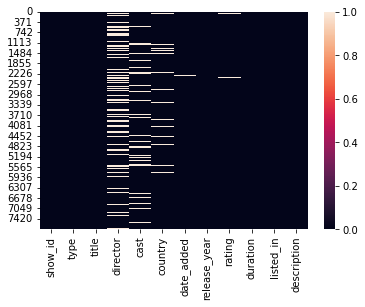

In [3]:
sns.heatmap(data.isnull());

In [4]:
drop_columns = ['show_id', 'date_added', 'release_year', 'duration']
for col in drop_columns:
    data.drop(col, axis=1, inplace=True)

In [5]:
data.columns

Index(['type', 'title', 'director', 'cast', 'country', 'rating', 'listed_in',
       'description'],
      dtype='object')

In [6]:
def calc_movie_feature_matrix(feature_column):
    isNan = False
    feature_list = []
    for i, items in enumerate(feature_column):
        if pd.isna(items):
            feature_list.append(['']) #place holder for nan values
            isNan = True
        else:
            item_list = re.split(r', \s*', items)
            feature_list.append(item_list)
        
    flatten_features = [item for sublist in feature_list for item in sublist]
    unique_features = list(np.unique(flatten_features))
    
    if isNan == True: # check if Nan value was passed through.
        unique_features = unique_features[1:] # '' is at index 0. this removes that value from list.
    
    index = {} #key: feature's name  value: column index
    for i, name in enumerate(unique_features):
        index[name] = i

    matrix = np.zeros((feature_column.shape[0], len(unique_features))) # (#movies, #unique features)

    for i, items in enumerate(feature_list): # update matrix with 
        movie = np.zeros(len(unique_features)) # movie array w/ all 0's
        if len(items) > 1:
            for item in items:
                movie[index[item]] = 1.0
            matrix[i] = movie
        elif items == ['']:
            matrix[i] = movie
        else:
            movie[index[items[0]]] = 1.0
            matrix[i] = movie
    return matrix

In [7]:
def jacsim(feature_matrix):
    """
    Create item-item similarity using Jaccard similarity
    J(A,B) = |A union B| / | A intersect B|
    
    """
    jacc_sim = np.zeros((feature_matrix.shape[0],feature_matrix.shape[0]))
    a = feature_matrix
    b = feature_matrix.T

    intersection = a @ b

    a_mag = a.sum(axis=1)
    a_mag= a_mag.reshape((len(a_mag),1))
    b_mag = b.sum(axis=0)

    union = (a_mag + b_mag) - intersection

    jacc_sim = np.divide(intersection, union, out=np.zeros_like(intersection), where=union!=0)

    return jacc_sim

In [8]:
def cossim(feature_matrix):
    """
    Create item-item similarity using Cosine Similarity
    cossim = A dot B / ||A||*||B||
    """
    cos_sim = np.zeros((feature_matrix.shape[0],feature_matrix.shape[0]))
    a = feature_matrix
    b = feature_matrix.T
    
    numerator = a @ b
    
    a_mag = np.sqrt((a**2).sum(axis=1))     # ||A||
    a_mag = a_mag.reshape((len(a_mag),1))   # ||A|| reshaped to to help with matrix multiplication
    b_mag = np.sqrt((b**2).sum(axis=0))     # ||B||

    denominator = a_mag * b_mag             # ||A|| * ||B||

    cos_sim = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0) #      (A dot B) / ||A||*||B||  
    return cos_sim

In [9]:
def get_recommendation(title, similarity_matrix):
        if title in list(data['title']):
            movie_indices = pd.Series(data.index, index= data['title'])
            idx = movie_indices[title]
            sim_scores = enumerate(similarity_matrix[idx])
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            top_5_sim_scores = sim_scores[1:6]
            top_5_index = [x[0] for x in top_5_sim_scores]
            result = data.iloc[top_5_index]
            print(sim_scores[0:6])
            return result
        else:
            print('Title Not Found')

In [10]:
movie_director = calc_movie_feature_matrix(data['director'])
movie_cast = calc_movie_feature_matrix(data['cast'])
movie_country = calc_movie_feature_matrix(data['country'])
movie_rating = calc_movie_feature_matrix(data['rating'])
movie_genre = calc_movie_feature_matrix(data['listed_in'])
feature_matrix = np.concatenate((movie_director, movie_cast, movie_country, movie_rating, movie_genre), axis = 1)

In [11]:
jaccard_similarity = jacsim(feature_matrix)
cosine_similarity = cossim(feature_matrix)

In [12]:
get_recommendation('Austin Powers: International Man of Mystery', jaccard_similarity)

[(626, 1.0), (627, 0.55), (625, 0.45), (1893, 0.16666666666666666), (210, 0.15384615384615385), (2036, 0.15384615384615385)]


,type,title,director,cast,country,rating,listed_in,description
627,Movie,Austin Powers: The Spy Who Shagged Me,Jay Roach,"Mike Myers, Heather Graham, Michael York, Robe...",United States,PG-13,"Action & Adventure, Comedies, Sci-Fi & Fantasy",When diabolical genius Dr. Evil travels back i...
625,Movie,Austin Powers in Goldmember,Jay Roach,"Mike Myers, Beyoncé Knowles-Carter, Seth Green...",United States,PG-13,"Action & Adventure, Comedies",The world's most shagadelic spy continues his ...
1893,Movie,Dumb and Dumberer: When Harry Met Lloyd,Troy Miller,"Eric Christian Olsen, Derek Richardson, Rachel...",United States,PG-13,Comedies,This wacky prequel to the 1994 blockbuster goe...
210,Movie,A Night at the Roxbury,John Fortenberry,"Will Ferrell, Chris Kattan, Dan Hedaya, Molly ...",United States,PG-13,"Comedies, Cult Movies","After a run-in with Richard Grieco, dimwits Do..."
2036,Movie,Eurovision Song Contest: The Story of Fire Saga,David Dobkin,"Will Ferrell, Rachel McAdams, Dan Stevens, Mel...",United States,PG-13,"Comedies, Music & Musicals, Romantic Movies",Two small-town singers chase their pop star dr...


In [146]:
get_recommendation('Dark', jaccard_similarity)

[(1610, 1.0), (4481, 0.20833333333333334), (3098, 0.18518518518518517), (7200, 0.18518518518518517), (3013, 0.18181818181818182), (6033, 0.18181818181818182)]


,type,title,director,cast,country,rating,listed_in,description
4481,TV Show,"Nisman: The Prosecutor, the President, and the...",Justin Webster,NaN,"Spain, Germany, Denmark, United States",TV-MA,"Crime TV Shows, Docuseries, International TV S...",This docuseries details the suspicious death o...
3098,TV Show,Jack Taylor,Stuart Orme,"Iain Glen, Killian Scott, Nora-Jane Noone, Tar...","United States, Ireland",TV-MA,"Crime TV Shows, International TV Shows, TV Dramas",Ken Bruen's bestselling crime novels leap to l...
7200,TV Show,Travelers,NaN,"Eric McCormack, MacKenzie Porter, Nesta Cooper...","Canada, United States",TV-MA,"Crime TV Shows, International TV Shows, TV Dramas",A federal agent tracks four people who suddenl...
3013,TV Show,Inside the Criminal Mind,NaN,NaN,"United States, Czech Republic",TV-MA,"Crime TV Shows, Docuseries, International TV S...",Explore the psychological machinations and imm...
6033,TV Show,Terrorism Close Calls,NaN,NaN,"United States, Czech Republic",TV-MA,"Crime TV Shows, Docuseries, International TV S...",Law enforcement officials look back on attempt...


In [147]:
get_recommendation('American Psycho', jaccard_similarity)

[(473, 1.0), (1288, 0.19230769230769232), (170, 0.18518518518518517), (2631, 0.16666666666666666), (3431, 0.16666666666666666), (6722, 0.16666666666666666)]


,type,title,director,cast,country,rating,listed_in,description
1288,Movie,Chasing Amy,Kevin Smith,"Ben Affleck, Joey Lauren Adams, Jason Lee, Dwi...",United States,R,"Comedies, Cult Movies, Dramas",Comic book artist Holden meets the perfect wom...
170,Movie,A Family Man,Mark Williams,"Gerard Butler, Gretchen Mol, Alison Brie, Will...","Canada, United States",R,Dramas,A ruthless corporate headhunter battles his ri...
2631,Movie,Harold & Kumar Go to White Castle,Danny Leiner,"John Cho, Kal Penn, Paula Garcés, Neil Patrick...","United States, Canada, Germany",R,"Comedies, Cult Movies",Buddies Harold and Kumar set out to satisfy a ...
3431,Movie,Kodachrome,Mark Raso,"Ed Harris, Jason Sudeikis, Elizabeth Olsen","Canada, United States",TV-MA,"Comedies, Dramas","A record company exec joins his estranged dad,..."
6722,Movie,The One I Love,Charlie McDowell,"Mark Duplass, Elisabeth Moss, Ted Danson",United States,R,"Comedies, Dramas, Independent Movies",Confronted with the potential end of their mar...


In [148]:
get_recommendation('Stranger Things', cosine_similarity)

[(5836, 1.0), (876, 0.7419408268023742), (6958, 0.35634832254989923), (6953, 0.29277002188455997), (4959, 0.2672612419124244), (1109, 0.25197631533948484)]


,type,title,director,cast,country,rating,listed_in,description
876,TV Show,Beyond Stranger Things,NaN,"Jim Rash, Matt Duffer, Ross Duffer, Shawn Levy...",United States,TV-14,"Stand-Up Comedy & Talk Shows, TV Mysteries, TV...","Secrets from the ""Stranger Things 2"" universe ..."
6958,TV Show,The Umbrella Academy,NaN,NaN,"United States, Canada",TV-14,"TV Action & Adventure, TV Mysteries, TV Sci-Fi...","Reunited by their father's death, estranged si..."
6953,TV Show,The Twilight Zone (Original Series),NaN,Rod Serling,United States,TV-14,"Classic & Cult TV, TV Sci-Fi & Fantasy","Hosted by creator Rod Serling, this groundbrea..."
4959,TV Show,Prank Encounters,NaN,Gaten Matarazzo,United States,TV-MA,"Reality TV, TV Comedies, TV Horror",Monstrous frights meet hilarious reveals on th...
1109,TV Show,Broken,NaN,NaN,United States,TV-14,Docuseries,This investigative docuseries shows how neglig...


In [149]:
get_recommendation('Hook', jaccard_similarity)

[(2799, 1.0), (708, 0.17391304347826086), (857, 0.16666666666666666), (6069, 0.16), (2992, 0.15384615384615385), (2993, 0.15384615384615385)]


,type,title,director,cast,country,rating,listed_in,description
708,Movie,Balto,Simon Wells,"Kevin Bacon, Bob Hoskins, Bridget Fonda, Jim C...",United States,G,"Children & Family Movies, Dramas","Balto, who is half wolf and half dog, endures ..."
857,Movie,Bethany Hamilton: Unstoppable,Aaron Lieber,Bethany Hamilton,United States,PG,"Children & Family Movies, Documentaries, Sport...",This documentary follows the rising tide of Be...
6069,Movie,The Adventures of Tintin,Steven Spielberg,"Jamie Bell, Andy Serkis, Daniel Craig, Nick Fr...","United States, New Zealand, United Kingdom",PG,Children & Family Movies,This 3-D motion capture adapts Georges Remi's ...
2992,Movie,Indiana Jones and the Raiders of the Lost Ark,Steven Spielberg,"Harrison Ford, Karen Allen, Paul Freeman, Rona...",United States,PG,"Action & Adventure, Children & Family Movies, ...",When Indiana Jones is hired by the government ...
2993,Movie,Indiana Jones and the Temple of Doom,Steven Spielberg,"Harrison Ford, Kate Capshaw, Amrish Puri, Rosh...",United States,PG,"Action & Adventure, Children & Family Movies, ...","Indiana Jones, his young sidekick and a spoile..."


In [150]:
get_recommendation('Peaky Blinders', cosine_similarity)

[(4806, 1.0), (1386, 0.3442651863295481), (2886, 0.3442651863295481), (3014, 0.3442651863295481), (4104, 0.3442651863295481), (5862, 0.3442651863295481)]


,type,title,director,cast,country,rating,listed_in,description
1386,TV Show,Churchill’s Secret Agents: The New Recruits,NaN,NaN,United Kingdom,TV-MA,"British TV Shows, International TV Shows, Real...","In this history-steeped reality series, 14 con..."
2886,TV Show,I AM A KILLER,NaN,NaN,United Kingdom,TV-MA,"British TV Shows, Crime TV Shows, Docuseries",Death row inmates convicted of capital murder ...
3014,TV Show,Inside The Freemasons,NaN,NaN,United Kingdom,TV-MA,"British TV Shows, Docuseries, International TV...",Explore the history and future of the Freemaso...
4104,TV Show,Million Pound Menu,NaN,NaN,United Kingdom,TV-MA,"British TV Shows, International TV Shows, Real...",Next-gen restaurateurs get the chance to open ...
5862,TV Show,Stunt Science,NaN,NaN,United Kingdom,TV-MA,"British TV Shows, International TV Shows, Real...",When it comes to daring stunts and outrageous ...


In [132]:
# c_description = clean_text(data)
# tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.95, norm = 'l2')
# tfidf = tfidf_vectorizer.fit_transform(c_description)
# cos_sim = linear_kernel(tfidf, tfidf)

In [133]:
# get_recommendation('Peaky Blinders', cos_sim)

[(3452, 1.0), (7683, 0.13434339215316093), (8293, 0.12068897329800551), (2646, 0.11862150098155227), (3133, 0.11837692250723159), (7140, 0.11405485220406086)]


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
7683,s7684,Movie,Our Godfather,"Mark Franchetti, Andrew Meier",Tommaso Buscetta,United Kingdom,"September 10, 2019",2019,TV-MA,93 min,"Documentaries, International Movies","In 1986, Tommaso Buscetta became the first top..."
8293,s8294,TV Show,The Fear,Michael Samuels,"Peter Mullan, Anastasia Hille, Harry Lloyd, Pa...",United Kingdom,"March 31, 2017",2012,TV-MA,1 Season,"British TV Shows, Crime TV Shows, TV Dramas",Richie Beckett is an aging Brighton crime boss...
2646,s2647,Movie,My Stupid Boss,Upi Avianto,"Bunga Citra Lestari, Reza Rahadian, Alex Abbad...",Indonesia,"April 23, 2020",2016,TV-G,107 min,"Comedies, International Movies","After moving to Kuala Lumpur, Diana lands a se..."
3133,s3134,Movie,Don,Farhan Akhtar,"Shah Rukh Khan, Priyanka Chopra, Arjun Rampal,...",India,"December 15, 2019",2006,TV-14,169 min,"Action & Adventure, International Movies",A ruthless crime boss and drug lord is nabbed ...
7140,s7141,TV Show,Jonathan Strange & Mr Norrell,Toby Haynes,"Eddie Marsan, Bertie Carvel, Marc Warren, Char...",United Kingdom,"August 25, 2016",2015,TV-14,1 Season,"British TV Shows, TV Dramas, TV Sci-Fi & Fantasy","In 1806, ambitious magician Norrell leads a re..."


### TF-IDF

In [19]:
tv_shows = data[data['type'] == 'TV Show']
movies = data[data['type'] == 'Movie']
tv_shows.reset_index(inplace=True)
movies.reset_index(inplace=True)

In [94]:
def clean_text(df):
    stop_words = stopwords.words('english')
    removed_stop_words = df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    cleaned_description = []
    for i, v in enumerate(removed_stop_words):
        lower_case_desc = v.lower()
        cleaned_description.append(lower_case_desc) 
    df = df.assign(c_description=cleaned_description)
    return df.c_description

In [112]:
def clean_text2(df): #with lementing, but made shit worse
    wordnet_lemmatizer = WordNetLemmatizer()
    
    stop_words = stopwords.words('english')
    removed_stop_words = df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    cleaned_description = []
    for i, v in enumerate(removed_stop_words):
        string = re.sub(r'[^-\w\s]+', '', removed_stop_words[i]) #
        string = re.sub(r'[^\w\s]+', ' ', string) #replaced - with space
        string = re.sub(' +', ' ', string) #removes any extra space
        lower_case_desc = string.lower()
        token_text = word_tokenize(lower_case_desc)
        lem = [wordnet_lemmatizer.lemmatize(word.lower()) for word in token_text] 
        cleaned_description.append(" ".join(lem)) 
    df = df.assign(c_description=cleaned_description)
    return df.c_description


    

In [22]:
c_description = clean_text(tv_shows)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.95, norm = 'l2')
tfidf = tfidf_vectorizer.fit_transform(c_description)
cos_sim = linear_kernel(tfidf, tfidf)

In [23]:
def get_recommendation_tv(title, similarity_matrix):
        if title in list(tv_shows['title']):
            movie_indices = pd.Series(tv_shows.index, index= tv_shows['title'])
            idx = movie_indices[title]
            sim_scores = enumerate(similarity_matrix[idx])
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            top_5_sim_scores = sim_scores[1:6]
            top_5_index = [x[0] for x in top_5_sim_scores]
            result = tv_shows.iloc[top_5_index]
            print(top_5_sim_scores)
            return result
        else:
            print('Title Not Found')

In [24]:
def get_recommendation_movie(title, similarity_matrix):
        if title in list(data['title']):
            movie_indices = pd.Series(movies.index, index= movies['title'])
            idx = movie_indices[title]
            sim_scores = enumerate(similarity_matrix[idx])
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            top_5_sim_scores = sim_scores[1:6]
            top_5_index = [x[0] for x in top_5_sim_scores]
            result = movies.iloc[top_5_index]
            print(top_5_sim_scores)
            return result
        else:
            print('Title Not Found')

In [25]:
get_recommendation_tv('After Life', cos_sim)

[(2359, 0.23300665026325257), (2071, 0.16020843294637402), (1228, 0.15911713296343213), (321, 0.12636237511246606), (2069, 0.11626680358555272)]


,index,type,title,director,cast,country,rating,listed_in,description
2359,7637,TV Show,Winter Sun,NaN,"Şükrü Özyıldız, Aslı Enver, Şenay Gürler, Başa...",Turkey,TV-MA,"International TV Shows, TV Dramas, TV Thrillers",Years after ruthless businessmen kill his fath...
2071,6739,TV Show,The Paper,NaN,"Branka Katić, Trpimir Jurkic, Aleksandar Cvetk...",Croatia,TV-MA,"International TV Shows, TV Dramas",A construction magnate takes over a struggling...
1228,4048,TV Show,Merry Happy Whatever,NaN,"Dennis Quaid, Bridgit Mendler, Brent Morin, As...",United States,TV-PG,TV Comedies,A struggling LA musician tries to win over his...
321,1193,TV Show,"Can't Cope, Won't Cope",NaN,"Seána Kerslake, Nika McGuigan, Sheila Moylette...",Ireland,TV-MA,"TV Comedies, TV Dramas","In Dublin, friends Aisling and Danielle must c..."
2069,6727,TV Show,The Originals,NaN,"Joseph Morgan, Daniel Gillies, Phoebe Tonkin, ...",United States,TV-14,"TV Dramas, TV Horror, TV Mysteries",The Mikaelsons move to New Orleans and form an...


In [26]:
get_recommendation_tv('After Life', cos_sim)

[(2359, 0.23300665026325257), (2071, 0.16020843294637402), (1228, 0.15911713296343213), (321, 0.12636237511246606), (2069, 0.11626680358555272)]


,index,type,title,director,cast,country,rating,listed_in,description
2359,7637,TV Show,Winter Sun,NaN,"Şükrü Özyıldız, Aslı Enver, Şenay Gürler, Başa...",Turkey,TV-MA,"International TV Shows, TV Dramas, TV Thrillers",Years after ruthless businessmen kill his fath...
2071,6739,TV Show,The Paper,NaN,"Branka Katić, Trpimir Jurkic, Aleksandar Cvetk...",Croatia,TV-MA,"International TV Shows, TV Dramas",A construction magnate takes over a struggling...
1228,4048,TV Show,Merry Happy Whatever,NaN,"Dennis Quaid, Bridgit Mendler, Brent Morin, As...",United States,TV-PG,TV Comedies,A struggling LA musician tries to win over his...
321,1193,TV Show,"Can't Cope, Won't Cope",NaN,"Seána Kerslake, Nika McGuigan, Sheila Moylette...",Ireland,TV-MA,"TV Comedies, TV Dramas","In Dublin, friends Aisling and Danielle must c..."
2069,6727,TV Show,The Originals,NaN,"Joseph Morgan, Daniel Gillies, Phoebe Tonkin, ...",United States,TV-14,"TV Dramas, TV Horror, TV Mysteries",The Mikaelsons move to New Orleans and form an...


In [27]:
get_recommendation_movie('Hook', cos_sim)

[(1435, 0.11609816342652843), (729, 0.10771714480538544), (779, 0.10478164023365995), (1927, 0.09492108475745697), (1013, 0.09357276763381683)]


,index,type,title,director,cast,country,rating,listed_in,description
1435,2042,Movie,Evening Shadows,Sridhar Rangayan,"Mona Ambegaonkar, Anant Mahadevan, Devansh Dos...",India,TV-PG,"Dramas, Independent Movies, International Movies","When her son comes out to her as gay, a religi..."
729,974,Movie,Bleach The Movie: Fade to Black,Noriyuki Abe,"Masakazu Morita, Fumiko Orikasa, Aya Hirano, H...",Japan,TV-PG,"Action & Adventure, Anime Features, Sci-Fi & F...",When his mind is fogged by a scimitar-weilding...
779,1053,Movie,Born Beautiful,Perci Intalan,"Martin del Rosario, Lou Veloso, Chai Fonacier,...",Philippines,TV-MA,"Comedies, Dramas, International Movies","After her best friend dies, Barbs attempts to ..."
1927,2780,Movie,Holy Goalie,Curro Velázquez,"Karra Elejalde, Alain Hernández, Juan Manuel M...",Spain,TV-MA,"Comedies, International Movies, Sports Movies",A young priest coaches a team of uncoordinated...
1013,1402,Movie,City of Joy,Madeleine Gavin,NaN,"United States,",TV-MA,Documentaries,Women who've been sexually brutalized in war-t...


In [28]:
# def calc_movie_cast_matrix():
#     movie_cast = []
#     for i, names in enumerate(data['cast']):
#         if pd.isna(names):
#             movie_cast.append(['']) #place holder for nan values
#         else:
#             cast_members = re.split(r', \s*', names)
#             movie_cast.append(cast_members)

#     actors = [item for sublist in movie_cast for item in sublist]
#     unique_actors = list(np.unique(actors))
#     unique_actors = unique_actors[1:] # '' is at index 0. this removes that value from list.

#     index = {} #key: actor's name value: column index
#     for i, name in enumerate(unique_actors):
#         index[name] = i

#     matrix = np.zeros((7787, len(unique_actors))) #(#movies, #unique actors)

#     for i , names in enumerate(movie_cast):
#         movie = np.zeros(len(unique_actors))
#         if len(names) > 1:
#             for name in names:
#                 movie[index[name]] = 1.0
#             matrix[i] = movie
#         elif names == ['']:
#             matrix[i] = movie 
#         else:
#             movie[index[names[0]]] = 1.0
#             matrix[i] = movie

#     return matrix

In [29]:
# # creates a movie director matrix of shape (7787, 4478)
# def create_movie_director():
#     movie_directors = []
#     for i, names in enumerate(data['director']):
#         if pd.isna(names):
#             movie_directors.append(['']) #place holder for Nan values
#         else:
#             director = re.split(r', \s*', names)
#             movie_directors.append(director)

#     all_directors = [item for sublist in movie_directors for item in sublist]
#     unique_directors = list(np.unique(all_directors))
#     unique_directors = unique_directors[1:]


#     index = {} # key: director name value: column index.
#     for i, name in enumerate(unique_directors):
#         index[name] = i

#     matrix = np.zeros((7787, len(unique_directors))) # (#movies, #uniquedirectors)

#     for i , names in enumerate(movie_directors):
#         movie = np.zeros(len(unique_directors))
#         if len(names) > 1:
#             for name in names:
#                 movie[index[name]] = 1.0
#             matrix[i] = movie
#         elif names == ['']:
#             matrix[i] = movie 
#         else:
#             movie[index[names[0]]] = 1.0
#             matrix[i] = movie
            
#     return matrix

In [30]:
# create_movie_director().shape

In [31]:
# # creates a movie, director matrix of shape (7787,4049)
# def create_movie_director():
        
#     unique_directors = [] #gets all unique director names
#     for name in data['director'].unique():
#         if pd.notna(name):
#             unique_directors.append(name)

#     index = {} # key: director name value: columns index.
#     for i, name in enumerate(unique_directors):
#         index[name] = i


#     matrix = np.zeros((7787, 4049)) # (#movies, #uniquedirectors)

#     for i , name in enumerate(data['director']):
#         movie = np.zeros(len(unique_directors))
#         if pd.isna(name):
#             matrix[i] = movie 
#         else:
#             movie[index[name]] = 1.0
#             matrix[i] = movie
            
#     return matrix
